<img src="https://upload.wikimedia.org/wikipedia/commons/d/df/Logo_UNIR.png" width="350" height="175">

# *TFM: Comparación y optimización de algoritmos de Machine Learning sobre el éxito de campañas de marketing bancarias*

Autor: ***Jorge López Pérez***

***

## ***10. Búsqueda y ajuste de umbrales de decisión***

A lo largo de este cuaderno, buscaremos los mejores umbrales de decisión para cada uno de nuestros modelos.

In [ ]:
!pip install scikit-learn==1.4.2

In [ ]:
!pip install scikeras

In [ ]:
import pandas as pd
import numpy as np
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import FunctionTransformer
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone
import warnings
import time
import matplotlib.pyplot as plt
import seaborn as sns

#modelos
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from tensorflow import keras
from sklearn.ensemble import RandomForestClassifier
import xgboost
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.ensemble import VotingClassifier
from scikeras.wrappers import KerasClassifier

#metricas
from sklearn.metrics import average_precision_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_recall_curve

#encoders
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import LabelEncoder

#imputers
from sklearn.impute import KNNImputer

#escalers
from sklearn.preprocessing import StandardScaler

warnings.filterwarnings("ignore")

Leemos los datos ya transformados:

In [ ]:
x_train_prepared = pd.read_csv('https://raw.githubusercontent.com/JorgeLopez88/TFM/main/data/transformed_data/x_train_prepared.csv').to_numpy()
x_test_prepared = pd.read_csv('https://raw.githubusercontent.com/JorgeLopez88/TFM/main/data/transformed_data/x_test_prepared.csv').to_numpy()
y_train_prepared = pd.read_csv('https://raw.githubusercontent.com/JorgeLopez88/TFM/main/data/transformed_data/y_train_prepared.csv').to_numpy()
y_test_prepared = pd.read_csv('https://raw.githubusercontent.com/JorgeLopez88/TFM/main/data/transformed_data/y_test_prepared.csv').to_numpy()

print(x_train_prepared.shape)
print(x_test_prepared.shape)
print(y_train_prepared.shape)
print(y_test_prepared.shape)

(34999, 33)
(6177, 33)
(34999, 1)
(6177, 1)


***

#### 10.1 Definición de modelos

In [ ]:
def build_rn_optimizado():
  inputs = keras.Input(shape=(x_train_prepared.shape[1],))

  hidden1 = keras.layers.Dense(64, activation='tanh', kernel_regularizer=keras.regularizers.L2(0.0001))(inputs)
  hidden1 = keras.layers.Dropout(0.3)(hidden1)

  hidden2 = keras.layers.Dense(32, activation='tanh', kernel_regularizer=keras.regularizers.L2(0.0001))(hidden1)
  hidden2 = keras.layers.Dropout(0.03)(hidden2)

  hidden3 = keras.layers.Dense(16, activation='tanh', kernel_regularizer=keras.regularizers.L2(0.0001))(hidden2)
  hidden3 = keras.layers.Dropout(0.03)(hidden3)

  hidden4 = keras.layers.Dense(8, activation='tanh', kernel_regularizer=keras.regularizers.L2(0.0001))(hidden3)
  outputs = keras.layers.Dense(1, activation='sigmoid')(hidden4)

  model = keras.Model(inputs=inputs, outputs=outputs)
  model.compile(optimizer=keras.optimizers.Adam(learning_rate= 0.001), loss='binary_crossentropy', metrics=[keras.metrics.AUC(curve='PR', name='auc_pr')])
  return model

In [ ]:
best_params_lr = {
    'random_state': 44,
    'penalty': 'l2', 'solver': 'liblinear', 'tol': 0.009981344185968627, 'C': 0.0446691778043737, 'max_iter': 115
}

best_params_dt = {
    'random_state': 44,
    'criterion': 'entropy', 'splitter': 'best', 'max_depth': 11, 'min_samples_split': 17, 'min_samples_leaf': 12, 'max_features': None, 'max_leaf_nodes': 58
}

best_params_knn = {
    'n_neighbors': 50, 'algorithm': 'brute', 'leaf_size': 32, 'p': 2
}

best_params_rf = {
    'random_state': 44,
    'n_estimators': 217, 'criterion': 'log_loss', 'max_depth': 22, 'min_samples_split': 16, 'min_samples_leaf': 2, 'max_features': None, 'max_leaf_nodes': 115
}

best_params_xgb = {
    'random_state': 44,
    'objective': 'binary:logistic', 'n_estimators': 663, 'max_depth': 7, 'learning_rate': 0.008783201476590967, 'subsample': 0.9982562365165706, 'colsample_bytree': 0.6330211837686112, 'colsample_bylevel': 0.5337460744463578, 'min_child_weight': 7, 'gamma': 0.0018843588248896698, 'lambda': 0.013059187310266722
}

best_params_hist = {
    'random_state': 44,
    'learning_rate': 0.014973674237963659, 'max_iter': 326, 'max_leaf_nodes': 27, 'max_depth': 9, 'min_samples_leaf': 17, 'l2_regularization': 8.790025433222111e-06, 'max_bins': 140, 'early_stopping': False
}

best_params_rn = {
    'model': build_rn_optimizado,
    'epochs': 60,
    'batch_size': 64,
    'verbose': 0,
    'random_state': 44,
}

best_params_voting= {
    'voting' : 'soft',
    'weights' : [0.07706639223827505, 0.2543946849801558, 0.12439539774863495, 0.05917170893708934, 0.3646432394020082, 0.8664926603286063, 0.7899967421503448]
}

In [ ]:
def initialize_models():

  estimators = [
      ('lr', LogisticRegression(**best_params_lr)),
      ('dt', DecisionTreeClassifier(**best_params_dt)),
      ('kn', KNeighborsClassifier(**best_params_knn)),
      ('rn', KerasClassifier(**best_params_rn)),
      ('rf', RandomForestClassifier(**best_params_rf)),
      ('xgb', xgboost.XGBClassifier(**best_params_xgb)),
      ('hist', HistGradientBoostingClassifier(**best_params_hist))
  ]

  dict_estimators = dict(estimators)

  voting = VotingClassifier(estimators=estimators, **best_params_voting)
  dict_estimators['voting'] = voting

  return dict_estimators

***

#### 10.2 Búsqueda de umbrales óptimos

Para encontrar los mejores umbrales, lo que haremos será generar las predicciones en validación cruzada de los datos de entrenamiento. Con estas predicciones calcularemos la curva precision-recall (es decir, tendremos las precisiones y recalls para cada umbral).

Ya con las precisiones y recalls de cada umbral calcularemos el umbral donde la diferencia entre ambos es mínima (con el objetivo de maximizar ambos por igual).

In [ ]:
models = initialize_models()

Funciones que utilizaremos:

In [ ]:
#grafica las curvas de precision y recall y el umbral óptimo, donde se minimiza la diferencia entre ambas
def precision_recall_tradeoff(precisions, recalls, thresholds, x_line=0.5, model_name='model_name'):
    fig, ax = plt.subplots(figsize=(8,5))
    plt.plot(thresholds, precisions[:-1], "#FF0000", label="Precisions")
    plt.plot(thresholds, recalls[:-1], "#424242", label="Recalls")
    plt.title(f"Precision y Recall Tradeoff - {model_name}", fontsize=15)
    plt.ylabel("Rendimientos Precision y Recall", fontsize=12)
    plt.xlabel("Thresholds", fontsize=12)
    plt.legend(loc="best", fontsize=10)
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.axvline(x=x_line, linewidth=1, color="#0B3861")

    plt.show()

#calcula las predicciones de los datos de entrenamiento en CV
def preds_probas_cv(estimator,x,y):
  skf = StratifiedKFold(n_splits=5, shuffle=True,random_state=44)

  probas_preds = np.zeros(x.shape[0])

  for i, (train_idx, test_idx) in enumerate(skf.split(x, y)):

    X_train, X_test = x[train_idx], x[test_idx]
    Y_train, Y_test = y[train_idx], y[test_idx]

    model = clone(estimator)
    model.fit(X_train, Y_train)
    preds_fold = model.predict_proba(X_test)[:,1]

    probas_preds[test_idx] = preds_fold

  return probas_preds

#busca el mejor umbral (donde la diferencia entre ambas es mínima)
def encontrar_mejor_umbral(precisions, recalls, thresholds, model_name):
  diffs = np.abs(precisions - recalls)

  best_threshold = thresholds[np.argmin(diffs)]
  best_precision = precisions[np.argmin(diffs)]
  best_recall = recalls[np.argmin(diffs)]

  print(f"Mejor umbral para el modelo {model_name}: ", best_threshold)
  print(f"Mejor precision para el moodelo {model_name}: ", best_precision)
  print(f"Mejor recall para el modelo {model_name}: ", best_recall)


***

Calculamos el mejor umbral para cada modelo:

##### 10.2.1 Regresión logística

In [ ]:
preds_probas = preds_probas_cv(models['lr'], x_train_prepared, y_train_prepared)
precisions, recalls, thresholds = precision_recall_curve(y_train_prepared, preds_probas, drop_intermediate=True)
encontrar_mejor_umbral(precisions,recalls,thresholds,'LR')

Mejor umbral para el modelo LR:  0.30956306346334556
Mejor precision para el moodelo LR:  0.5926959168146082
Mejor recall para el modelo LR:  0.5926959168146082


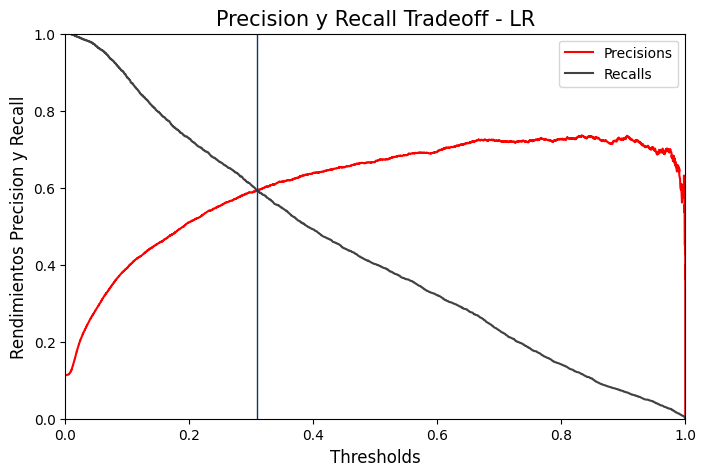

In [ ]:
precision_recall_tradeoff(precisions,recalls, thresholds, 0.30956306346334556, 'LR')

***

##### 10.2.2 Árbol de decisión

In [ ]:
preds_probas = preds_probas_cv(models['dt'], x_train_prepared, y_train_prepared)
precisions, recalls, thresholds = precision_recall_curve(y_train_prepared, preds_probas, drop_intermediate=True)
encontrar_mejor_umbral(precisions,recalls,thresholds,'DT')

Mejor umbral para el modelo DT:  0.45
Mejor precision para el moodelo DT:  0.6145482785399948
Mejor recall para el modelo DT:  0.6020796347958407


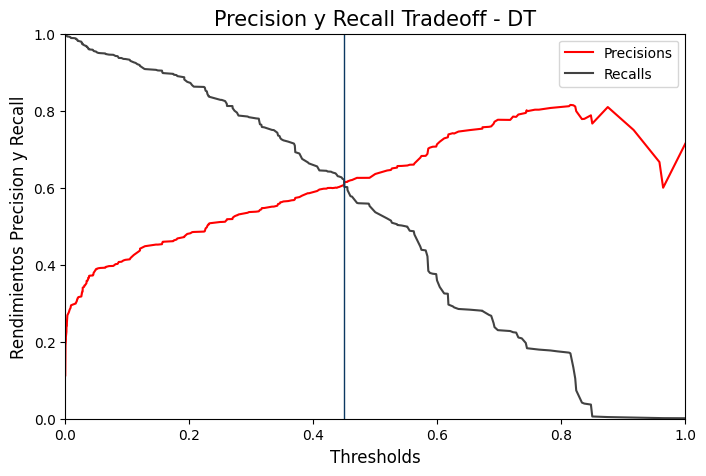

In [ ]:
precision_recall_tradeoff(precisions,recalls, thresholds, 0.45, 'DT')

***

##### 10.2.3 Kneighbors

In [ ]:
preds_probas = preds_probas_cv(models['kn'], x_train_prepared, y_train_prepared)
precisions, recalls, thresholds = precision_recall_curve(y_train_prepared, preds_probas, drop_intermediate=True)
encontrar_mejor_umbral(precisions,recalls,thresholds,'KNN')

Mejor umbral para el modelo KNN:  0.34
Mejor precision para el moodelo KNN:  0.5630383711824589
Mejor recall para el modelo KNN:  0.5470453969059093


(Reajustamos umbral al 0.335 para minimizar diferencia)

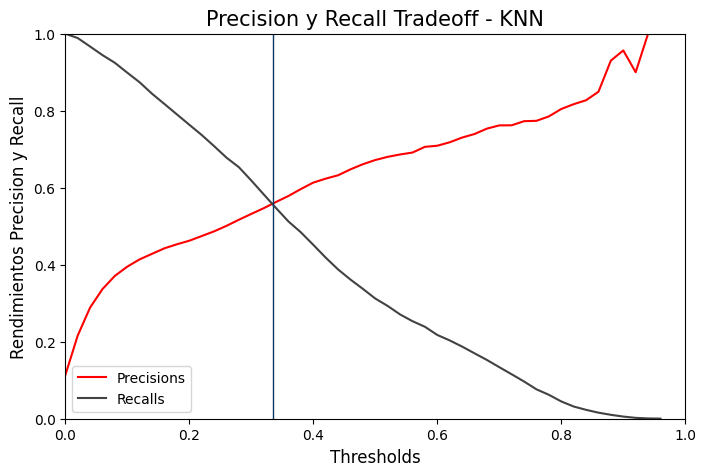

In [ ]:
precision_recall_tradeoff(precisions,recalls, thresholds, 0.335, 'KNN')

***

##### 10.2.4 Red neuronal

In [ ]:
preds_probas = preds_probas_cv(models['rn'], x_train_prepared, y_train_prepared)
precisions, recalls, thresholds = precision_recall_curve(y_train_prepared, preds_probas, drop_intermediate=True)
encontrar_mejor_umbral(precisions,recalls,thresholds,'RN')

Mejor umbral para el modelo RN:  0.4619227945804596
Mejor precision para el moodelo RN:  0.6033477047933046
Mejor recall para el modelo RN:  0.6033477047933046


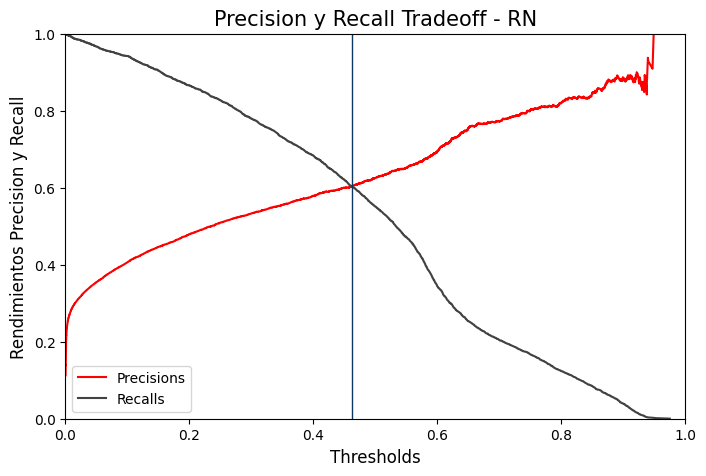

In [ ]:
precision_recall_tradeoff(precisions,recalls, thresholds, 0.4619227945804596, 'RN')

***

##### 10.2.5 Random Forest

In [ ]:
preds_probas = preds_probas_cv(models['rf'], x_train_prepared, y_train_prepared)
precisions, recalls, thresholds = precision_recall_curve(y_train_prepared, preds_probas, drop_intermediate=True)
encontrar_mejor_umbral(precisions,recalls,thresholds,'RF')

Mejor umbral para el modelo RF:  0.4409208877853789
Mejor precision para el moodelo RF:  0.626172964747654
Mejor recall para el modelo RF:  0.626172964747654


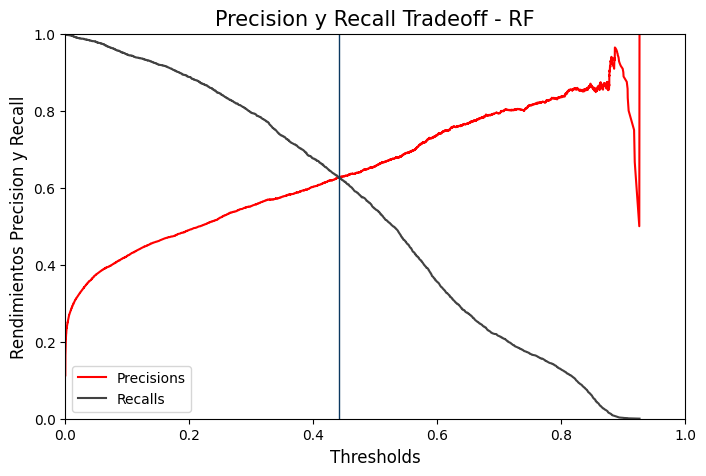

In [ ]:
precision_recall_tradeoff(precisions,recalls, thresholds, 0.4409208877853789, 'RF')

***

##### 10.2.6 XGBoost

In [ ]:
preds_probas = preds_probas_cv(models['xgb'], x_train_prepared, y_train_prepared)
precisions, recalls, thresholds = precision_recall_curve(y_train_prepared, preds_probas, drop_intermediate=True)
encontrar_mejor_umbral(precisions,recalls,thresholds,'XGB')

Mejor umbral para el modelo XGB:  0.41521722078323364
Mejor precision para el moodelo XGB:  0.6287091047425818
Mejor recall para el modelo XGB:  0.6287091047425818


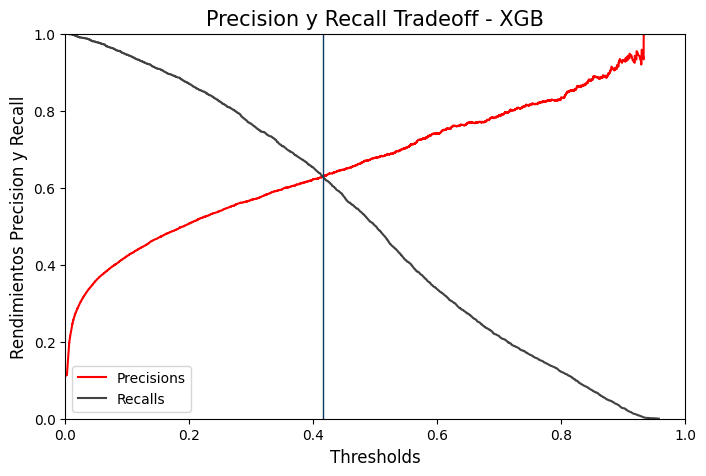

In [ ]:
precision_recall_tradeoff(precisions,recalls, thresholds, 0.41521722078323364, 'XGB')

***

##### 10.2.7 Hist Gradient Boosting

In [ ]:
preds_probas = preds_probas_cv(models['hist'], x_train_prepared, y_train_prepared)
precisions, recalls, thresholds = precision_recall_curve(y_train_prepared, preds_probas, drop_intermediate=True)
encontrar_mejor_umbral(precisions,recalls,thresholds,'HIST')

Mejor umbral para el modelo HIST:  0.4376945586668581
Mejor precision para el moodelo HIST:  0.6316856780735107
Mejor recall para el modelo HIST:  0.6320060867359878


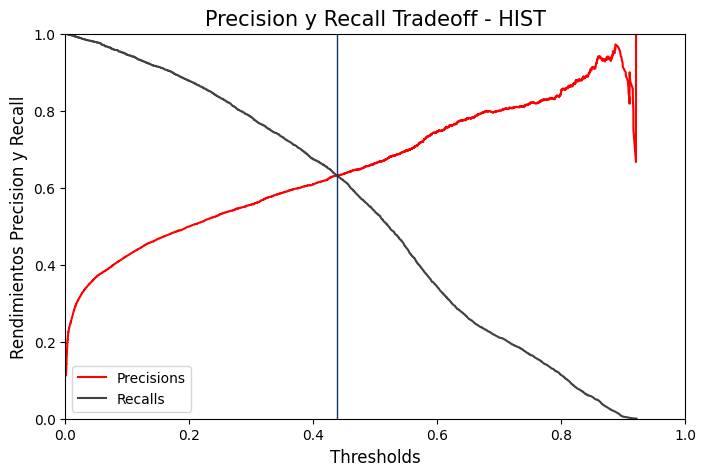

In [ ]:
precision_recall_tradeoff(precisions,recalls, thresholds, 0.4376945586668581, 'HIST')

***

##### 10.2.8 Voting

In [ ]:
preds_probas = preds_probas_cv(models['voting'], x_train_prepared, y_train_prepared)
precisions, recalls, thresholds = precision_recall_curve(y_train_prepared, preds_probas, drop_intermediate=True)
encontrar_mejor_umbral(precisions,recalls,thresholds,'VOTING')

Mejor umbral para el modelo VOTING:  0.4239847736394669
Mejor precision para el moodelo VOTING:  0.6327669287344662
Mejor recall para el modelo VOTING:  0.6327669287344662


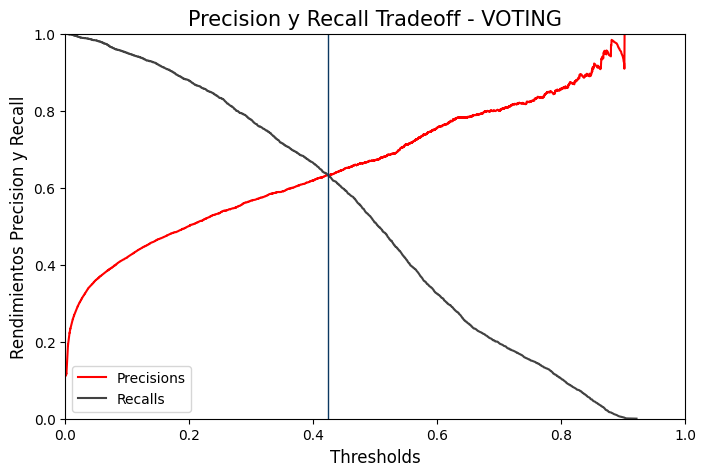

In [ ]:
precision_recall_tradeoff(precisions,recalls, thresholds, 0.4239847736394669, 'VOTING')

***

#### 10.3 Cálculo de métricas

Funciones para cálculo de métricas:

In [ ]:
def probas_to_abs(probas, umbral=0.5):
  abs = []
  for proba in probas:
    if (proba >= umbral): abs.append(1)
    else: abs.append(0)
  return abs

def calculate_cv_metrics(estimator,x,y, umbral_decision):
  skf = StratifiedKFold(n_splits=5, shuffle=True,random_state=44)

  scores_auc_pr = []
  scores_precision = []
  scores_recall = []
  scores_f1 = []
  scores_accuracy = []
  scores_roc = []

  for i, (train_idx, test_idx) in enumerate(skf.split(x, y)):

    X_train, X_test = x[train_idx], x[test_idx]
    Y_train, Y_test = y[train_idx], y[test_idx]

    model = clone(estimator)
    model.fit(X_train, Y_train)
    preds_test = model.predict_proba(X_test)[:,1]

    scores_auc_pr.append(average_precision_score(Y_test, preds_test))
    scores_precision.append(precision_score(Y_test, probas_to_abs(preds_test, umbral_decision)))
    scores_recall.append(recall_score(Y_test, probas_to_abs(preds_test, umbral_decision)))
    scores_f1.append(f1_score(Y_test, probas_to_abs(preds_test, umbral_decision)))
    scores_accuracy.append(accuracy_score(Y_test, probas_to_abs(preds_test, umbral_decision)))
    scores_roc.append(roc_auc_score(Y_test, preds_test))

  mean_auc_pr = round(np.mean(scores_auc_pr), 4)
  mean_precision = round(np.mean(scores_precision), 4)
  mean_recall = round(np.mean(scores_recall), 4)
  mean_f1 = round(np.mean(scores_f1), 4)
  mean_accuracy = round(np.mean(scores_accuracy), 4)
  mean_roc = round(np.mean(scores_roc), 4)

  return mean_auc_pr, mean_precision, mean_recall, mean_f1, mean_accuracy, mean_roc


def calculate_pr_cv(umbrales_decision):
  modelos = initialize_models()
  scores = []
  for key, model in modelos.items():
      score,_,_,_,_,_ = calculate_cv_metrics(model, x_train_prepared, y_train_prepared, umbrales_decision[key])
      scores.append(score)
      print(f'CV -> AUC PR score for {key}: ', score)
  print('')
  print('Mean AUC PR score: ', round(np.mean(scores), 4))


def calculate_baseline_metrics_cv(umbrales_decision):
  modelos = initialize_models()
  for key, model in modelos.items():
      auc_pr, precision, recall, f1,_,_ = calculate_cv_metrics(model, x_train_prepared, y_train_prepared, umbrales_decision[key])
      print(f'CV -> AUC PR score for {key}: ', auc_pr)
      print(f'CV -> Precision score for {key}: ', precision)
      print(f'CV -> Recall score for {key}: ', recall)
      print(f'CV -> F1 score for {key}: ', f1)
      print('')
      print('**********************************')
      print('')

***

#### 10.4 Métricas CV tras ajustar umbrales de decisión


In [ ]:
umbrales_decision = {
    'lr': 0.30956306346334556,
    'dt': 0.45,
    'kn': 0.335,
    'rn': 0.4619227945804596,
    'rf': 0.4409208877853789,
    'xgb': 0.41521722078323364,
    'hist': 0.4376945586668581,
    'voting': 0.4239847736394669
}

In [ ]:
calculate_baseline_metrics_cv(umbrales_decision)

CV -> AUC PR score for lr:  0.5888
CV -> Precision score for lr:  0.5929
CV -> Recall score for lr:  0.5927
CV -> F1 score for lr:  0.5927

**********************************

CV -> AUC PR score for dt:  0.6329
CV -> Precision score for dt:  0.618
CV -> Recall score for dt:  0.6021
CV -> F1 score for dt:  0.6073

**********************************

CV -> AUC PR score for kn:  0.5741
CV -> Precision score for kn:  0.5634
CV -> Recall score for kn:  0.5471
CV -> F1 score for kn:  0.5548

**********************************

CV -> AUC PR score for rn:  0.6457
CV -> Precision score for rn:  0.606
CV -> Recall score for rn:  0.6034
CV -> F1 score for rn:  0.6023

**********************************

CV -> AUC PR score for rf:  0.6702
CV -> Precision score for rf:  0.6268
CV -> Recall score for rf:  0.6262
CV -> F1 score for rf:  0.6262

**********************************

CV -> AUC PR score for xgb:  0.672
CV -> Precision score for xgb:  0.6292
CV -> Recall score for xgb:  0.6287
CV -> F1 sco

***